# Systems of Linear Equations

In [2]:
import subprocess
import sys

# Zorg ervoor dat schemdraw geïnstalleerd is
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "schemdraw"])

import matplotlib.pyplot as plt
import numpy as np
import schemdraw
import schemdraw.elements as elm
from scipy import linalg, optimize
from timeit import default_timer as timer

## Introduction and Notation


Many physical systems show *linear* behaviour:
- Newton's second law of motion $F=ma$
- Ohm's law : $R=\frac{U}{I}$
- Hooke's law: $F_s=kx$
- ...

In some cases, we have an entire *system of coupled equations* which relate several "causes" with corresponding "effects". For instance, in an electrical circuit containing many conductors, Ohm's and Kirchoff's laws allow us to write a system of equations describing the relationship between the voltages and currents.

In general, such a system of $m$ linear equations with $n$ can be written as:

$$
\begin{cases}
a_{11}x_1+a_{12}x_{2}+\cdots+a_{1n}x_{n}=b_{1}\\
a_{21}x_1+a_{22}x_{2}+\cdots+a_{2n}x_{n}=b_{2}\\
\hspace{2cm}\vdots\\
a_{m1}x_{1}+a_{m2}x_{2}+\cdots+a_{mn}x_{n}=b_{n}\\
\end{cases}
$$

We transform this into a matrix notation by expressing e.g. all the currents in a vector $\mathbf{x}$ and all voltages in a vector $\mathbf{b}$. The linear transformation between these two vector spaces is represented by a *matrix* $\mathbf{A}$.

Thus, a system of $m$ linear equations with $n$ unknowns can be transformed into a $m \times n$ matrix:

$$
\begin{bmatrix}
a_{11} & a_{12} & \cdots & a_{1n}\\
a_{21} & a_{22} & \cdots & a_{2n}\\
\vdots& \vdots& \ddots & \vdots\\
a_{m1} & a_{m2} & \cdots & a_{mn}\\
\end{bmatrix}\begin{bmatrix}x_1\\x_2\\\vdots\\x_n\end{bmatrix}=\begin{bmatrix}b_1\\b_2\\\vdots\\b_n\end{bmatrix}
$$

Such a relation can be used to predict $\mathbf{b}$ by a matrix-vector multiplication $\mathbf{b}=\mathbf{A}\mathbf{x}$.

More interestingly, we can ask the question: "if we know $\mathbf{b}$, can we then reconstruct $\mathbf{x}$?

In this chapter, we will answer this question. Here, we will assume that we have an equal amount of *unknowns* as we have *equations*, i.e. a *square* system.

**Example: Electrical Circuit** 

Consider the electrical circuit shown below, consisting of two voltage sources and three resistances.
We wish to determine the currents in the loops in the circuit by applying

**Ohm's law**: The voltage drop across a resistance in the direction of a current I is given by IR.

**Kirchhoff's voltage law**: The net voltage drop in a closed loop is zero.

and

**Kirchhoff's current law**: For every junction in a circuit the sum of currents flowing in is equal to the currents flowing out



> Note on the figure below. The arrow indicating the current direction labeled $I_2$ should point down.
> If this is not the case for you, you might have an older version of schemdraw. 
> You can update with `pip install -U schemdraw`. Version 0.17 (or newer) gives the correct result.

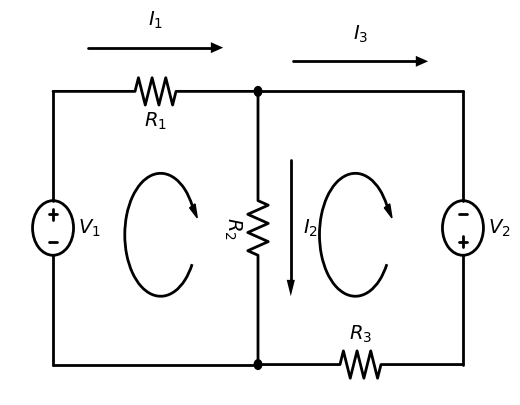

In [3]:
def draw_circuit():
    plt.close("circuit")
    fig, ax = plt.subplots(num="circuit")
    ax.set_axis_off()
    with schemdraw.Drawing(ax, unit=5) as d:
        V1 = elm.SourceV().label("$V_1$", loc="bot")
        d += V1
        R1 = elm.Resistor().right().label("$R_1$", loc="bot")
        d += R1
        d += elm.CurrentLabel(length=3.3, ofst=0.55).at(R1).label("$I_1$")
        d += elm.Dot()
        d.push()
        R2 = elm.Resistor().down().label("$R_2$", rotate=True)
        d += R2
        d += elm.CurrentLabel(top=True, length=2.5, ofst=0.55).at(R2).label("$I_2$")
        d += elm.Dot()
        d.pop()
        L1 = elm.Line()
        d += L1
        V2 = elm.SourceV().down().label("$V_2$", loc="bot")
        d += V2
        R3 = elm.Resistor().left().label("$R_3$")
        d += R3
        L2 = elm.Line().left().tox(V1.start)
        d += L2
        d += elm.CurrentLabel(length=3.3, ofst=0.55).at(L1).label("$I_3$")
        d += elm.LoopCurrent([R1, R2, L2, V1], pad=1.25)
        d += elm.LoopCurrent([R1, V2, L2, R2], pad=1.25)


draw_circuit()

Applying these laws to each loop in the current results in the following system of three equations:

$$
\begin{cases}
I_{1} - I_{2} - I_{3}=0\\
I_{1}R_{1}+I_{2}R_{2}=V_{1}\\
-I_{2}R_{2}+I_{3}R_{3}=V_{2}\\
\end{cases}
$$

which can be written in matrix form as

$$\begin{bmatrix}
1 & -1 & -1\\
R_{1} & R_{2}& 0 \\
0 & -R_{2} & +R_{3}\\
\end{bmatrix}\begin{bmatrix}I_1\\I_2\\I_{3}\end{bmatrix}=\begin{bmatrix}0\\V_1\\V_2\end{bmatrix}$$

With the methods learned below, you'll be able to solve this system.



An $n\times n$ matrix is called *nonsingular* if it satisfies any one of the following equivalent conditions:
- $\mathbf{A}$ has an inverse  $\mathbf{A}^{-1}$ such that $\mathbf{A}^{-1}\mathbf{A}$=$\mathbf{I}$ (the identity matrix)
- $\operatorname{det}(\mathbf{A})\neq 0$
- $\operatorname{rank}(\mathbf{A})=n$ (the **rank** of matrix is the maximum number of linearly independent rows or columns it contains)
- for any vector $\mathbf{z}\neq0$, $\mathbf{A}\mathbf{z}$ also must be nonzero.

A system with a nonsingular matrix always has one unique solution $\mathbf{x}=\mathbf{A}^{-1}\mathbf{b}$.
A system with a singular matrix either has no solution or infinitely many solutions, depending on the vector $\mathbf{b}$.




In two dimensions this is easy to visualize. Each linear equation represents a straight line in the plane. The solution of the system is the intersection between those lines. *If* they are not parallel, they have a unique intersection point (the nonsingular case). If they are parallel they either do not intersect at all (no solution) or they coincide (infinitely many solutions).

## Solving Linear Systems 

### Strategy

To solve a linear system $\mathbf{Ax}=\mathbf{b}$, our general strategy is to transform our problem in another one whose solution is easier to compute. To this end we can premultiply (multiply from the left) both sides by *any* nonsingular matrix $M$, without affecting our solution:

To see why, note that the solution to the system

$$\mathbf{MAz}=\mathbf{Mb}$$

is given by

$$\mathbf{z}=(\mathbf{MA})^{-1}\mathbf{Mb}=\mathbf{A}^{-1}\mathbf{M}^{-1}\mathbf{Mb}=\mathbf{A}^{-1}\mathbf{b}=\mathbf{x}$$


> **Example**
>
> A simple example of such a transformation is a permutation $\mathbf{P}$ which reorders the rows of $\mathbf{A}$ and the corresponding entries of $\mathbf{b}$.
> It's easy to see that this does not change the solution $\mathbf{x}$ as all of the equations in the system must be satisfied simultaneously, so the order in which they are written down is irrelevant.
>
> The permutation matrix $\mathbf{P}$ is a square matrix with exactly one 1 in each row and zeros elsewhere.
>
> e.g.
> 
> $$
\begin{bmatrix}
0 & 0 & 1 \\
1 & 0 & 0 \\
0 & 1 & 0 
\end{bmatrix}  \begin{bmatrix}
x_1  \\
x_2 \\
x_3  
\end{bmatrix} = \begin{bmatrix}
x_3  \\
x_1 \\
x_2  
\end{bmatrix}
$$

The next question we need to answer is what systems are computationally easy to solve?

The answer to this question is a **triangular linear system**.

Such a system contains one row with only one nonzero entry, such that one of the unknowns can easily be determined. The system also contains a row with two nonzero entries, one of which is already determined, and so on...
A matrix with these properties is called a **triangular matrix** and is easy to solve by successive substitution. Note that only square or $n \times n$ matrices can be triangular.

Although the general triangular form described above is all that is required to enable the system to be solved by successive substitution, it is convenient to define two specific triangular forms for computational purposes: lower and upper triangular matrices. Any triangular matrix can be permuted into upper or lower triangular form by a suitable permutation of its rows or columns.

A matrix $\mathbf{L}$ is **lower triangular** if all of its entries above the main diagonal are zero ($l_{ij}=
0$ if $i<j$):

$$\begin{bmatrix}
a_{11} & 0 & \cdots & 0 \\
a_{21} & a_{22} & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
a_{n1} & a_{n2} & \cdots & a_{nn}
\end{bmatrix}$$

A lower triangular system $\mathbf{Lx}=\mathbf{b}$ can be solved by **forward substitution**, mathematically expressed as

$$
x_1=b_1/l_{11},\quad x_i=\left(b_i-\sum^{i-1}_{j=1}l_{ij}x_j\right)/l_{ii} \quad\mathrm{for}\quad i=2,\ldots,n
$$

> **Example**
>
> As an example let's use this approach on the lower triangular system:
>
> $$ \begin{bmatrix}
1 & 0 & 0 \\
2 & 1 & 0 \\
-1 & 0.5 & -1 
\end{bmatrix}  \begin{bmatrix}
x_1  \\
x_2 \\
x_3  
\end{bmatrix} = \begin{bmatrix}
2  \\
4 \\
2  
\end{bmatrix}$$
>
> For such a simple system, we can easily calculate by hand that the solution is:
>
> $x_1=2$
>
> $x_2=\frac{4-(2\cdot2)}{1}=0$
>
> $x_3=\frac{2-(-1\cdot2+0\cdot0.5)}{-1}=-4$
>
> The following cell shows an implementation which does this automatically to confirm our answer:


In [4]:
def forward_substitution(L, b):
    n = len(L)
    x = np.zeros(n)
    for j in range(n):
        if L[j][j] == 0:  # stop if matrix is singular
            break
        x[j] = b[j] / L[j][j]
        for i in range(j, n):
            b[i] = b[i] - L[i][j] * x[j]
    return x


L = np.array([[1, 0, 0], [2, 1, 0], [-1, 0.5, -1]])
b = np.array([2, 4, 2])

x = forward_substitution(L, b)
x

array([ 2.,  0., -4.])

A matrix $\mathbf{U}$ is **upper triangular** if all of its entries *below* the main diagonal are zero 
($u_{ij}=0$ if $i>j$):

$$ \begin{bmatrix}
a_{11} & a_{12} & \cdots & a_{1n} \\
0 & a_{22} & \cdots & a_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & a_{nn}
\end{bmatrix}  $$

An upper triangular system $\mathbf{Ux}=\mathbf{b}$ can be solved by **backward substitution**, mathematically expressed as

$$
x_n=b_n/u_{nn},\quad x_i=\left(b_i-\sum^{n}_{j=1+i}u_{ij}x_j\right)/u_{ii} \quad\mathrm{for}\quad i=n-1,\ldots,1
$$


This can similarly be solved as illustrated on the following example:
> **Example**
>
> As an example let us use this approach on the lower triangular system:
>
> $$ \begin{bmatrix}
1 & 2 & 2 \\
0 & -4 & -6 \\
0 & 0 & -1 
\end{bmatrix}  \begin{bmatrix}
x_1  \\
x_2 \\
x_3  
\end{bmatrix} = \begin{bmatrix}
3  \\
-6 \\
1  
\end{bmatrix}$$
>
> $x_3=-1$
>
> $x_2=\frac{-6-(-6\cdot(-1))}{-4}=3$
>
> $x_1=\frac{3-(2\cdot3+2\cdot(-1))}{1}=-1$
>
> The following cell shows an implementation which does this automatically to confirm our answer:

In [5]:
def backward_substitution(U, b):
    n = len(U)
    x = np.zeros(n)
    # Note that he last value of range is exclusive,
    # which is very counter-intuitive for countdowns.
    for j in range(n - 1, -1, -1):
        if U[j][j] == 0:  # stop if matrix is singular
            break
        x[j] = b[j] / U[j][j]
        for i in range(0, j):
            b[i] = b[i] - U[i][j] * x[j]
    return x


U = np.array([[1, 2, 2], [0, -4, -6], [0, 0, -1]])
b = np.array([3, -6, 1])

x = backward_substitution(U, b)
x

array([-1.,  3., -1.])

### Elementary elimination matrices

What we need is a nonsingular linear transformation that transforms a given linear system into a triangular linear system, which we can subsequently solve.

Thus, we need a transformation that replaces selected nonzero entries of the given matrix with zeros.
This can be accomplished by taking appropriate linear combinations of the rows of the matrix

Generally, for an $n$-vector $\mathbf{a}$, we can annihilate *all* of its entries below the $k$th position (assuming $a_k \neq 0$) by the following transformation:

$$\mathbf{M}_k\mathbf{a}=\begin{bmatrix}
1 & \cdots & 0 & 0 & \cdots & 0 \\
\vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
0 & \cdots & 1 & 0 & \cdots & 0 \\
0 & \cdots & -m_{k+1} & 1 & \cdots & 0 \\
\vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
0 & \cdots & -m_n & 0 & \cdots & 1 
\end{bmatrix} \begin{bmatrix} a_1\\ \vdots\\ a_k \\a_{k+1}\\\vdots\\a_n\\\end{bmatrix}  = \begin{bmatrix} a_1\\ \vdots\\ a_k \\0\\\vdots\\0\\\end{bmatrix}$$

with $m_i=\frac{a_i}{a_k}\quad i=k+1,\cdots,n$

The divisor $a_k$ is called the **pivot**.
A matrix of this form is called an **elementary elimination matrix** or **Gauss transformation** and its effect on a vector is to add a multiple of row $k$ to each subsequent row with the multipliers $m_i$ chosen so that the result in each case is zero.


**Useful properties**:

- $\mathbf{M}_k=\mathbf{I}-\mathbf{m}_k\mathbf{e}_k^\intercal$, where $\mathbf{m}_k=[0,\cdots,0,m_{k+1},\cdots,m_n]^\intercal$ and $\mathbf{e}_k$ is the $k$th column of the identity matrix
- $\mathbf{M}_k^{-1}=\mathbf{I}+\mathbf{m}_k\mathbf{e}_k^\intercal$, which means that $\mathbf{M}_k^{-1}$, denoted as $\mathbf{L}_k$, is the same as $\mathbf{M}_k$, except that the signs of the multipliers are reversed.

> **Example**
>
> if $\mathbf{a}= [2, 4, -2]^\intercal$
>
> $$ \mathbf{M}_1\mathbf{a}=  \begin{bmatrix}
1 & 0 & 0 \\
-2 & 1 & 0 \\
1 & 0 & 1 
\end{bmatrix} \begin{bmatrix}
2 \\
4 \\
-2\\ 
\end{bmatrix}=\begin{bmatrix}
2 \\
0 \\
0\\ 
\end{bmatrix}$$
>
> and 
>
> $$\mathbf{M}_2\mathbf{a}=  \begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0.5 & 1 
\end{bmatrix} \begin{bmatrix}
2 \\
4 \\
-2\\ 
\end{bmatrix}=\begin{bmatrix}
2 \\
4 \\
0\\ 
\end{bmatrix}$$

### Gaussian Elimination and LU Factorization

Using elementary elimination matrices, it is relatively easy to reduce a general linear system $\mathbf{Ax}=\mathbf{b}$ to upper triangular form, using the following procedure called **Gaussian elimination**, **LU factorization** or **LU decomposition**:

- We first choose an elementary elimination matrix $\mathbf{M}_1$, with the first diagonal entry of $\mathbf{A}=a_{11}$ as the pivot, so that the first column of $\mathbf{M}_1\mathbf{A}$ becomes zero under the top element. The new system becomes $\mathbf{M}_1\mathbf{Ax}=\mathbf{M}_1\mathbf{b}$, which has the same solution.
- Next we use the second diagonal entry of $\mathbf{M}_1\mathbf{Ax}$ as pivot to determine $\mathbf{M}_2$, so that the second column of $\mathbf{M}_2\mathbf{M}_1\mathbf{A}$ becomes zero under the second element. The zeros in the first column under the top element are preserved. We obtain the system $\mathbf{M}_2\mathbf{M}_1\mathbf{Ax}=\mathbf{M}_2\mathbf{M}_1\mathbf{b}$.
- We keep doing this until the matrix is upper triangular.
- If we define the matrix $\mathbf{M}=\mathbf{M}_{n-1}\cdots\mathbf{M}_1$, then the transformed linear system $\mathbf{MAx}=\mathbf{Mb}$ is upper triangular and can be solved by back-substitution to obtain the solution of the original linear system $\mathbf{Ax}=\mathbf{b}$.

The name LU factorization comes from the fact that it decomposes the matrix $\mathbf{A}$ into a product of a lower triangular matrix $\mathbf{L}=\mathbf{M}^{-1}$, and an upper triangular matrix $\mathbf{U}=\mathbf{MA}$. 

Given such a factorization, the linear system $\mathbf{Ax}=\mathbf{b}$ can be written as $\mathbf{LUx}=\mathbf{b}$ and can be solved by first solving the lower triangular system $\mathbf{Ly}=\mathbf{b}$ by forward substitution, then the upper triangular system $\mathbf{Ux}=\mathbf{y}$ by back-substitution.

Note that the factorization phase can be skipped when solving additional systems having different right-hand-side vectors $\mathbf{b}$ but the same matrix $\mathbf{A}$, since $\mathbf{L}$ and $\mathbf{U}$ can be reused.


> **Example**
>
>
> As an example, let's solve the linear system
>
> $$\begin{aligned}
  2 x_1 + 7 x_2 + 5 x_3=& 6\\
-2 x_1 - 3 x_2 -  x_3=& 18\\
4 x_1 + 9 x_2 - 5 x_3=& 12\\
\end{aligned}$$
>
> In matrix notation this becomes
> 
> $$\mathbf{Ax}=\begin{bmatrix}
2 & 7 & 5 \\
-2 & -3 & -1 \\
4 & 9 & -5
\end{bmatrix} \begin{bmatrix}
x_1 \\
x_2 \\
x_3 
\end{bmatrix}=\begin{bmatrix}
6 \\
18 \\
12 
\end{bmatrix}=\mathbf{b}$$
>
> Using
> 
> $$\mathbf{M}_1=\begin{bmatrix}
1 & 0 & 0 \\
1 & 1 & 0 \\
-2 & 0 & 1 
\end{bmatrix}, $$
> 
> we find
> 
> $$\mathbf{M}_1\mathbf{A}=\begin{bmatrix}
2 & 7 & 5 \\
0 & 4 & 4 \\
0 & -5 & -15 
\end{bmatrix}$$
> 
> and
> 
> $$\mathbf{M}_1\mathbf{b}=\begin{bmatrix}
6 \\
24\\
0  
\end{bmatrix}$$
>
> Using 
>
> $$\mathbf{M}_2=\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & \frac{5}{4} & 1 
\end{bmatrix},$$
> 
> we find
>
> $$\mathbf{M}_2\mathbf{M}_1\mathbf{A}=\begin{bmatrix}
2 & 7 & 5 \\
0 & 4 & 4 \\
0 & 0 & -10 
\end{bmatrix}$$
> 
> and
> 
> $$\mathbf{M}_2\mathbf{M}_1\mathbf{b}=\begin{bmatrix}
6 \\
24\\
30 
\end{bmatrix}.$$
>
> By using $\mathbf{M}=\mathbf{M}_2 \mathbf{M}_1$ and $\mathbf{U} = \mathbf{MA}$,
> we have therefore reduced the original system to the equivalent upper triangular system
>
> $$
    \mathbf{Ux}=
    \begin{bmatrix}
        2 & 7 & 5 \\
        0 & 4 & 4 \\
        0 & 0 & -10 
    \end{bmatrix} 
    \begin{bmatrix}
        x_1 \\
        x_2 \\
        x_3 
    \end{bmatrix}=
    \begin{bmatrix}
        6 \\
        24 \\
        30 
    \end{bmatrix}
    =\mathbf{Mb}=\mathbf{y},
$$
>
> which can be solved by back-substitution, as shown in a previous example.
>
> Thus, the matrices $L_1$ and $L_2$ can be obtained from $M_1$ and $M_2$ according to the properties: 
>
> $$
\mathbf{L}_1 = \mathbf{M}_1^{-1} =  
    \begin{bmatrix}
        1 & 0 & 0 \\
        -1 & 1 & 0 \\
        2 & 0 & 1 
    \end{bmatrix} 
$$
> 
> and 
>
> $$
    \mathbf{L}_2 = \mathbf{M}_2^{-1} =  
    \begin{bmatrix}
        1 & 0   & 0 \\
        0 & 1   & 0 \\
        0 & -\frac{5}{4} & 1 
    \end{bmatrix} 
$$
>
> We can also write down the LU-factorization explicitly with
>
> $$
    \mathbf{L}=\mathbf{L}_1\mathbf{L}_2=
    \begin{bmatrix}
        1 & 0   & 0 \\
        -1 & 1   & 0 \\
        2 & -\frac{5}{4} & 1 
    \end{bmatrix} 
$$
>
> and
>  
> $$ 
    \mathbf{A} = \mathbf{I A} 
    = (\mathbf{M}_1^{-1} \mathbf{M}_2^{-1} \mathbf{M}_2 \mathbf{M}_1) \mathbf{A} 
    = (\mathbf{M}_1^{-1} \mathbf{M}_2^{-1}) (\mathbf{M}_2 \mathbf{M}_1 \mathbf{A})
    = (\mathbf{L}_1 \mathbf{L}_2) \mathbf{U}
    = \mathbf{L} \mathbf{U}.
$$
>
> As a result, we confirm that
>
> $$ 
    \mathbf{A} = 
    \begin{bmatrix}
        2 & 7 & 5 \\
        -2 & -3 & -1 \\
        4 & 9 & -5 
    \end{bmatrix} =
    \begin{bmatrix}
        1 & 0   & 0 \\
        -1 & 1   & 0 \\
        2 & -\frac{5}{4} & 1 
    \end{bmatrix}
    \begin{bmatrix}
        2 & 7 & 5 \\
        0 & 4 & 4 \\
        0 & 0 & -10 
    \end{bmatrix} = \mathbf{LU} 
$$ 

An algorithm to perform LU factorization by Gaussian elimination is shown below.
A note on the variable names used: it returns $\mathbf{L}$ and $\mathbf{U}$, despite using variables $\mathbf{M}$ and $\mathbf{A}$ in the algorithm!

In [6]:
def LU(A, verbose=False):
    """LU decomposition with Gaussian elimination.

    Parameters
    ----------
    A: np.array
        2d-square array.
    verbose: bool, default=False
        Whether print more infomation.

    Returns
    -------
    tuple
        (L,U)
    """
    U = np.copy(A)
    n = U.shape[0]
    L = np.identity(n)

    # loop columns
    for j in range(n):
        M_jth, L_jth = np.identity(n), np.identity(n)
        if U[j, j] == 0:  # stop if pivot is zero
            continue

        # loop rows
        for i in range(j + 1, n):
            M_jth[i, j] = -U[i, j] / U[j, j]
            L_jth[i, j] = -M_jth[i, j]

        if verbose:
            print(f" No.{j+1} iteration ".center(80, "*"))
            print("M: ")
            print(M_jth)
            print("L: ")
            print(L_jth)
            print("Current A")
            print(U)
            print(" end ".center(80, "-"))

        # update A, L, U
        L = L @ L_jth
        U = M_jth @ U
    return L, U

In [7]:
print("As an example consider the matrix A from the previous example:")
A = np.array([[2, 7, 5], [-2, -3, -1], [4, 9, -5]])
print(A)
print()

L, U = LU(A, verbose=True)
assert np.allclose(L @ U, A)

print("The matrices L and U read")
print(L)
print("and")
print(U)
print()
print("Let's check that their product indeed equals A")
print(L @ U)
print("For a given vector b, this system can now be solved as follows:")
b = np.array([6, 18, 12])

y = forward_substitution(L, b)
x = backward_substitution(U, y)
x

As an example consider the matrix A from the previous example:
[[ 2  7  5]
 [-2 -3 -1]
 [ 4  9 -5]]

******************************** No.1 iteration ********************************
M: 
[[ 1.  0.  0.]
 [ 1.  1.  0.]
 [-2.  0.  1.]]
L: 
[[ 1.  0.  0.]
 [-1.  1.  0.]
 [ 2.  0.  1.]]
Current A
[[ 2  7  5]
 [-2 -3 -1]
 [ 4  9 -5]]
------------------------------------- end --------------------------------------
******************************** No.2 iteration ********************************
M: 
[[1.   0.   0.  ]
 [0.   1.   0.  ]
 [0.   1.25 1.  ]]
L: 
[[ 1.    0.    0.  ]
 [ 0.    1.    0.  ]
 [ 0.   -1.25  1.  ]]
Current A
[[  2.   7.   5.]
 [  0.   4.   4.]
 [  0.  -5. -15.]]
------------------------------------- end --------------------------------------
******************************** No.3 iteration ********************************
M: 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
L: 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Current A
[[  2.   7.   5.]
 [  0.   4.   4.]
 [  0.   0. -10.]]
--------

array([-21.,   9.,  -3.])

### Partial pivoting 

There are 2 problems with the Gaussian elimination process:
1. The process breaks down if the leading diagonal entry of the matrix is zero at any stage because the multipliers for a given column require a division by the diagonal entry in that column.

- This issue is trivial to solve: when the diagonal entry is zero at stage $k$, then interchange row $k$ of the system (and the right-hand side vector) with some subsequent row with nonzero entry in column $k$. Such an interchange does not change the solution of the system and is called **pivoting**.

2. In finite-precision arithmetic we wish to limit the size of the multipliers so that previous rounding errors do not get amplified. 
- The multipliers will never exceed 1 in magnitude if for each column we choose the entry of the largest magnitude on or below the diagonal as a pivot. Such a policy is called **partial pivoting** and is essential in practice for a numerically stable implementation of Gaussian elimination.

> **Example**
>
> In the following example we'll perform the LU factorization for a matrix $\mathbf{A}$ without pivoting
>
> $$\mathbf{A}=\begin{bmatrix}
\epsilon & 1\\
1&1\\
\end{bmatrix}$$
>
> and with pivoting, i.e. with matrix 
>
> $$\mathbf{A}'=\begin{bmatrix}
1&1\\
\epsilon & 1\\
\end{bmatrix}$$

> We'll see that for $\epsilon= 1\times 10^{-16}$ (about the machine precision for doubles) the product $\mathbf{LU}$ no longer equals $\mathbf{A}$, whereas it gives the correct answer for $\mathbf{A}'$.

In [8]:
e = 1e-16
a = np.array([[e, 1], [1, 1]])
aprime = np.array([[1, 1], [e, 1]])

L, U = LU(a)
Lprime, Uprime = LU(aprime)

print(L @ U)
print(Lprime @ Uprime)

[[1.e-16 1.e+00]
 [1.e+00 0.e+00]]
[[1.e+00 1.e+00]
 [1.e-16 1.e+00]]


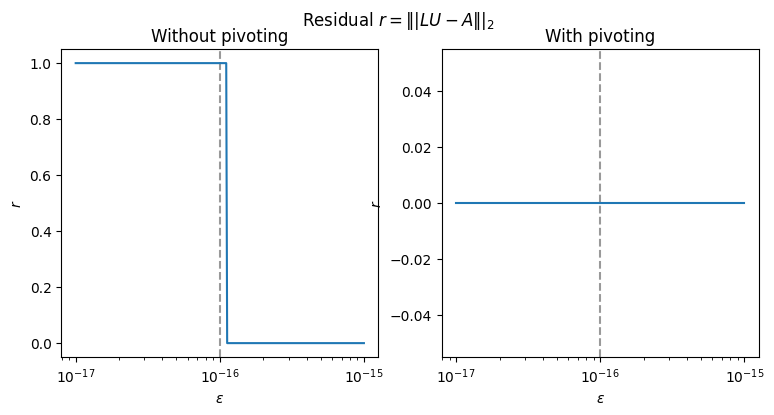

In [9]:
def compute_residual(eps_arr):
    res = np.zeros((len(eps_arr), 2))
    for i, eps in enumerate(eps_arr):
        a = np.array([[eps, 1], [1, 1]])
        aprime = np.array([[1, 1], [eps, 1]])
        L, U = LU(a)
        Lprime, Uprime = LU(aprime)
        res[i, 0] = linalg.norm(L @ U - a, 2)
        res[i, 1] = linalg.norm(Lprime @ Uprime - aprime, 2)
    return res


def plot_residual():
    plt.close("residual")
    fig, axs = plt.subplots(ncols=2, figsize=(9, 4), num="residual")
    for ax in axs:
        ax.set_xscale("log")
        ax.set_xlabel(r"$\epsilon$")
        ax.set_ylabel("$r$")
        ax.axvline(10 ** (-16), 0, 1, color="k", alpha=0.4, linestyle="--")

    eps_arr = np.linspace(10 ** (-17), 10 ** (-15), 600)
    res = compute_residual(eps_arr)

    axs[0].plot(eps_arr, res[:, 0])
    axs[0].set_title("Without pivoting")
    axs[1].plot(eps_arr, res[:, 1])
    axs[1].set_title("With pivoting")
    fig.suptitle(r"Residual $r=\|| LU - A \||_2$")


plot_residual()

The previous example is rather artificial, but in general, larger pivots result in smaller entries in the elimination matrix and hence smaller errors.

The Gaussian elimination procedure becomes a little more complicated as each elimination matrix is now preceded by a permutation matrix that interchanges rows to maximize the pivot value.

> **Example**
>
> Let's now repeat the previous example, but with partial pivoting.
>
> We again start from
> 
> $$\mathbf{Ax}=\begin{bmatrix}
2 & 7 & 5 \\
-2 & -3 & -1 \\
4 & 9 & -5 
\end{bmatrix} \begin{bmatrix}
x_1 \\
x_2 \\
x_3 
\end{bmatrix}=\begin{bmatrix}
6 \\
18 \\
12 
\end{bmatrix}=\mathbf{b}$$
>
> The largest entry in the first column is 4, so we interchange the first and last row using
>
> $$\mathbf{P}_1=\begin{bmatrix}
0 & 0 & 1 \\
0 & 1 & 0 \\
1 & 0 & 0 
\end{bmatrix}$$

> and obtain
>
> $$\mathbf{P}_1\mathbf{Ax}=\begin{bmatrix}
4 & 9 & -5 \\
-2 & -3 & -1 \\
2 & 7 & 5 
\end{bmatrix} \begin{bmatrix}
x_1 \\
x_2 \\
x_3 
\end{bmatrix}=\begin{bmatrix}
12 \\
18 \\
6 
\end{bmatrix}=\mathbf{P}_1\mathbf{b}$$
>
> To annihilate the subdiagonal entries of the first column, we use
>
> $$\mathbf{M}_1=\begin{bmatrix}
1 & 0 & 0 \\
0.5 & 1 & 0 \\
-0.5 & 0 & 1 
\end{bmatrix}$$
>
> To obtain the transformed system
>
> $$\mathbf{M}_1\mathbf{P}_1\mathbf{Ax}=\begin{bmatrix}
4 & 9 & -5 \\
0 & 1.5 & -3.5 \\
0 & 2.5 & 7.5 
\end{bmatrix} \begin{bmatrix}
x_1 \\
x_2 \\
x_3 
\end{bmatrix}=\begin{bmatrix}
12 \\
24 \\
0 
\end{bmatrix}=\mathbf{M}_1\mathbf{P}_1\mathbf{b}$$
>
> Similarly, we exchange the last two rows using $\mathbf{P}_2$ and use the elimination matrix $\mathbf{M}_2$:
>
> $$\mathbf{P}_2=\begin{bmatrix}
1 & 0 & 0 \\
0 & 0 & 1 \\
0 & 1 & 0 
\end{bmatrix}\quad \mathrm{and, }\quad \mathbf{M}_2=\begin{bmatrix}
1 &0 & 0 \\
0 & 1 & 0 \\
0 & -0.6 & 1 
\end{bmatrix}$$
>
> To obtain the transformed system
> 
> $$\mathbf{Ux}=\mathbf{M}_2\mathbf{P}_2\mathbf{M}_1\mathbf{P}_1\mathbf{Ax}=\begin{bmatrix}
4 & 9 & -5 \\
0 & 2.5 & 7.5 \\
0 & 0 & -8 
\end{bmatrix} \begin{bmatrix}
x_1 \\
x_2 \\
x_3 
\end{bmatrix}=\begin{bmatrix}
12 \\
0 \\
24 
\end{bmatrix}=\mathbf{M}_2\mathbf{P}_2\mathbf{M}_1\mathbf{P}_1\mathbf{b}$$
> 
> which can be solved by back-substitution.
>
> Again, we can write out the LU factorization explicitly, using
> 
> $$
\mathbf{L}=\mathbf{M}^{-1} =
(\mathbf{M}_2 \mathbf{P}_2 \mathbf{M}_1 \mathbf{P}_1)^{-1} =
\mathbf{P}_1^\intercal \mathbf{L}_1 \mathbf{P}_2^\intercal \mathbf{L}_2 =
$$
> 
> $$ \begin{bmatrix}
0 & 0 & 1 \\
0 & 1 & 0 \\
1 & 0 & 0 
\end{bmatrix}\begin{bmatrix}
1 & 0 & 0 \\
-0.5 & 1 & 0 \\
0.5 & 0 & 1 
\end{bmatrix}\begin{bmatrix}
1 & 0 & 0 \\
0 & 0 & 1 \\
0 & 1 & 0 
\end{bmatrix}\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0.6 & 1 
\end{bmatrix}=\begin{bmatrix}
0.5 & 1 & 0 \\
-0.5 & 0.6 & 1 \\
1 & 0 & 0 
\end{bmatrix}
$$
> 
> such that
>
> $$
\mathbf{A}= \begin{bmatrix}
2 & 7 & 5 \\
-2& -3 & -1 \\
4 & 9 & -5 
\end{bmatrix}= \begin{bmatrix}
0.5 & 1 & 0 \\
-0.5 & 0.6 & 1 \\
1 & 0 & 0 
\end{bmatrix}\begin{bmatrix}
4 & 9 & -5 \\
0 & 2.5 & 7.5 \\
0 & 0 & -8 
\end{bmatrix}=\mathbf{LU}
$$


Note that $\mathbf{L}$ is not longer lower diagonal, but still is a triangular matrix in the general sense that it is a permutation of a lower triangular matrix. There also exist alternative ways to write $\mathbf{L}$ depending on whether $\mathbf{P}$ is used to permute $\mathbf{A}$ or $\mathbf{L}$ itself. The notation used here is consistent with what is used in `scipy.linalg` with the option `permute_l=True`.

The following cell shows this algorithm which performs LU-factorization, including partial pivoting, resulting in $\mathbf{LU}$ equals matrix $\mathbf{A}$:

In [10]:
def LU_pivot(A, verbose=False):
    """LU decomposition with Gaussian elimination using permute.

    Parameters
    ----------
    A: np.array
        2d-square array.
    verbose: bool, default=True
        Whether print more infomation.

    Returns
    -------
    tuple
        (L,U)

    """
    U = np.copy(A)
    n = U.shape[0]
    L = np.identity(n)

    # loop columns
    for j in range(n):
        M_jth, L_jth, P_jth = (
            np.identity(n),
            np.identity(n),
            np.identity(n, dtype=int),
        )
        if U[j, j] == 0:  # stop if pivot is zero
            continue

        # look for the largest pivot
        index_largest = j
        for i in range(j + 1, n):
            if U[i][j] > U[index_largest][j]:
                index_largest = i

        if j != index_largest:  # swap rows
            U[[j, index_largest]] = U[[index_largest, j]]
            P_jth[[j, index_largest]] = P_jth[[index_largest, j]]

        # loop rows
        for i in range(j + 1, n):
            M_jth[i, j] = -U[i, j] / U[j, j]
            L_jth[i, j] = -M_jth[i, j]

        if verbose:
            print(f" No.{j+1} iteration ".center(80, "*"))
            print("P: ")
            print(P_jth)
            print("M: ")
            print(M_jth)
            print("L: ")
            print(L_jth)
            print("Current A")
            print(U)
            print(" end ".center(80, "-"))

        # update A, L, U
        L = L @ P_jth.T @ L_jth
        U = M_jth @ U
    return L, U

In [11]:
A = np.array([[2.0, 7.0, 5.0], [-2.0, -3.0, -1.0], [4.0, 9.0, -5.0]])
L, U = LU_pivot(A, verbose=True)

print(L, "\n\n", U)
assert np.allclose(L @ U, A)

******************************** No.1 iteration ********************************
P: 
[[0 0 1]
 [0 1 0]
 [1 0 0]]
M: 
[[ 1.   0.   0. ]
 [ 0.5  1.   0. ]
 [-0.5  0.   1. ]]
L: 
[[ 1.   0.   0. ]
 [-0.5  1.   0. ]
 [ 0.5  0.   1. ]]
Current A
[[ 4.  9. -5.]
 [-2. -3. -1.]
 [ 2.  7.  5.]]
------------------------------------- end --------------------------------------
******************************** No.2 iteration ********************************
P: 
[[1 0 0]
 [0 0 1]
 [0 1 0]]
M: 
[[ 1.   0.   0. ]
 [ 0.   1.   0. ]
 [ 0.  -0.6  1. ]]
L: 
[[1.  0.  0. ]
 [0.  1.  0. ]
 [0.  0.6 1. ]]
Current A
[[ 4.   9.  -5. ]
 [ 0.   2.5  7.5]
 [ 0.   1.5 -3.5]]
------------------------------------- end --------------------------------------
******************************** No.3 iteration ********************************
P: 
[[1 0 0]
 [0 1 0]
 [0 0 1]]
M: 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
L: 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Current A
[[ 4.   9.  -5. ]
 [ 0.   2.5  7.5]
 [ 0.   0.  -8. ]]
----

The name *partial* pivoting comes from the fact that only the current column is searched for a suitable pivot. **Complete pivoting** is a strategy in which the complete unreduced submatrix is searched for the largest entry, which is then permuted in the diagonal pivot position, which requires the interchanging of rows and columns. Without going into detail, it is worth noting that both in theory and in practice, the additional stability offered by complete pivoting is marginal and not worth the extra expense.

### Gauss-Jordan elimination

The goal in Gaussian elimination is to reduce a matrix to triangular form, because the resulting system is easy to solve. A diagonal form is even easier to solve, so it might appear attractive to try to reduce a matrix to this form. **Gauss-Jordan elimination** is a variation of Gaussian elimination which does this by not only annihilating the matrix entries below the diagonal but also above it, making it about 50% more computationally expensive than standard Gaussian elimination.

Typically, it is not used because
- The final solution phase is computationally somewhat cheaper because of the diagonal form of the matrix, but this does not suffice make up for the additional cost in the elimination phase.

However, it might be desirable in some situations:
- In an implementation on parallel computers, the workload remains the same throughout the elimination phase and the final solutions can all be calculated at once.
- It can also be used to calculate the inverse of a matrix explicitly by initializing the right-hand side of the matrix as the identity matrix $\mathbf{I}$.

> **Example: Mechanical System Equilibrium**
>
> Let us consider a system of three masses connected by springs in a vertical arrangement, subject to external forces.
> The equilibrium positions and forces can be expressed as follows:
>
> $$
\left\lbrace\begin{aligned}
3kx_1 - 2kx_2 &= F_1 \\
-2kx_1 + (3k - k)x_2 - 3kx_3 &= F_2 \\
-3kx_2 + 13kx_3 &= F_3
\end{aligned}\right.
$$
>
> Here, $x_1$, $x_2$, and $x_3$ represent the displacements of the masses, and $F_1$, $F_2$, and $F_3$ are the external forces applied to each mass.
> Let's consider the case where $F_1 = 1k$, $F_2 = 2k$ and $F_3 = 3k$.
> After dividing through $k$, one can write this system of linear equations in matrix form:
>
> $$\begin{bmatrix}
3 & -2 & 0 & \vert & 1 \\
-2 & 2 & -3 & \vert & 2 \\
0 & -3 & 13 & \vert & 3
\end{bmatrix}$$
>
> After using the first diagonal element as pivot, `row1 /= 3`, one gets:
>
> $$\begin{bmatrix}
1 & -\frac{2}{3} & 0 & \vert & \frac{1}{3} \\
-2 & 9 & -3 & \vert & 2 \\
0 & -3 & 13 & \vert & 3
\end{bmatrix}$$
>
> The first elimination is similar to LU: `row2 += 2 * row1`
>
> $$\begin{bmatrix}
1 & -\frac{2}{3} & 0 & \vert & \frac{1}{3} \\
0 & \frac{2}{3} & -3k & \vert & \frac{8}{3} \\
0 & -3 & 13 & \vert & 3
\end{bmatrix}$$
>
> Then one uses the second diagonal as pivot: `row2 /= (2/3)`
>
> $$\begin{bmatrix}
1 & -\frac{2}{3} & 0 & \vert & \frac{1}{3} \\
0 & 1 & -\frac{9}{2} & \vert & 4 \\
0 & -3 & 13 & \vert & 3
\end{bmatrix}$$
>
> Followed by elimination of coefficientbs *above and below* the diagonal: `row3 += 3 * row2` and `row1 += (2/3)*row2`
>
> $$\begin{bmatrix}
1 & 0 & -3 & \vert & 3 \\
0 & 1 & -\frac{9}{2} & \vert & 4 \\
 0 & 0 & -\frac{1}{2} & \vert & 15
\end{bmatrix}$$
>
> Finally, one use the last element as pivot and eleminates the coefficients above with similar upates:
>
> $$\begin{bmatrix}
1 & 0 & 0 & \vert & -87 \\
0 & 1 & 0 & \vert & 131 \\
0 & 0 & 1 & \vert & -30
\end{bmatrix}$$

In [12]:
def gauss_jordan_elimination(A, b):
    augmented_matrix = np.hstack((A.astype(float), b.astype(float)))
    rows, cols = augmented_matrix.shape

    result_matrices = [augmented_matrix.copy()]

    for pivot_row in range(rows):
        augmented_matrix[pivot_row] /= augmented_matrix[pivot_row, pivot_row]

        for other_row in range(rows):
            if other_row != pivot_row:
                factor = augmented_matrix[other_row, pivot_row]
                augmented_matrix[other_row] -= factor * augmented_matrix[pivot_row]

        result_matrices.append(augmented_matrix.copy())

    return result_matrices


def demo_gauss_jordan():
    # Example usage
    A = np.array([[3, -2, 0], [-2, 2, -3], [0, -3, 13]])
    b = np.array([[1], [2], [3]])

    result_matrices = gauss_jordan_elimination(A, b)

    # Print each intermediate matrix
    for i, result_matrix in enumerate(result_matrices):
        print(f"After {i} iteration{'s' if i > 1 else ''}:")
        print(result_matrix)
        print()

    # Print the final solution for x
    print("Final solution for x:")
    print(result_matrices[-1][:, -1])


demo_gauss_jordan()

After 0 iteration:
[[ 3. -2.  0.  1.]
 [-2.  2. -3.  2.]
 [ 0. -3. 13.  3.]]

After 1 iteration:
[[ 1.         -0.66666667  0.          0.33333333]
 [ 0.          0.66666667 -3.          2.66666667]
 [ 0.         -3.         13.          3.        ]]

After 2 iterations:
[[ 1.   0.  -3.   3. ]
 [ 0.   1.  -4.5  4. ]
 [ 0.   0.  -0.5 15. ]]

After 3 iterations:
[[   1.    0.    0.  -87.]
 [   0.    1.    0. -131.]
 [  -0.   -0.    1.  -30.]]

Final solution for x:
[ -87. -131.  -30.]


### Modified problems

In many practical situations linear systems do not occur in isolation but as part of a sequence of related problems. For example, one may need to solve a sequence of linear systems $\mathbf{Ax}=\mathbf{b}$ having the same matrix $\mathbf{A}$ but different right-hand sides $\mathbf{b}$. After having solved the initial system once, the factor $\mathbf{LU}$ can be used to solve the additional systems with a cost of $\mathcal{O}(n^2)$ instead of $\mathcal{O}(n^3)$, which is a substantial saving of work.

Additionally, there exist strategies to solve problems in which the matrix $\mathbf{A}$ is modified, but these lie beyond the scope of this course. 

## Special types of linear systems

In the algorithms discussed so far, we have assumed that the matrix is **dense** meaning that (almost) all the entries are nonzero.

If this is not the case and the matrix has some special properties, often there exist more efficient (in terms of storage or calculation time) ways to solve the linear system. A few examples are:

- **Symmetric**: $\mathbf{A}=\mathbf{A}^\intercal$, i.e. $a_{ij}=a_{ji}$ for all $i,j$
- **Positive definite**: $\mathbf{x^\intercal Ax}>0$ for all $\mathbf{x}\neq 0$
- **Banded**: $a_{ij}=0$ for all $|i-j|>\beta$, with $\beta$ the **bandwidth** of $\mathbf{A}$
- **Sparse**: most entries of $\mathbf{A}$ are zero

We'll have a detailed look at how to solve symmetric positive definite systems, as we'll encounter such systems later in the course when looking at *Linear least squares methods*.

### Symmetric positive definite systems: Cholesky factorization

If a matrix $\mathbf{A}$ is symmetric and positive definite, then an LU factorization can be arranged so that $\mathbf{U}=\mathbf{L}^\intercal$, meaning that $\mathbf{A}=\mathbf{LL}^\intercal$, where $\mathbf{L}$ is lower triangular.

This is known as **Cholesky factorization** of $\mathbf{A}$.
An algorithm for computing it can be derived by equating the corresponding entries of $\mathbf{A}$ and $\mathbf{LL}^\intercal$ and then generating the entries of $\mathbf{L}$ in the correct order.

E.g. in the 2D case we have:

$$\begin{bmatrix}
a_{11}\ & a_{12}  \\
a_{12} & a_{22} 
\end{bmatrix}=\begin{bmatrix}
l_{11}\ & 0  \\
l_{21} & l_{22} 
\end{bmatrix}\begin{bmatrix}
l_{11}\ & l_{21}  \\
0 & l_{22} 
\end{bmatrix}=\begin{bmatrix}
l_{11}^2\ & l_{11}l_{21}  \\
l_{11}l_{21} & l_{21}^2+l_{22}^2 
\end{bmatrix}$$

This implies
- $l_{11}=\sqrt{a_{11}}$
- $l_{21}=a_{12}/l_{11}$
- $l_{22}=\sqrt{a_{22}-l_{21}^2}$

In the 3D case we have:

$$\begin{bmatrix}
a_{11} & a_{12} & a_{13}  \\
a_{12} & a_{22} & a_{23} \\
a_{13} & a_{23} & a_{33} 
\end{bmatrix}=\begin{bmatrix}
l_{11}^2\ & l_{11}l_{21} & l_{11}l_{31} \\
l_{11}l_{21} & l_{21}^2+l_{22}^2 & l_{21}l_{31}+l_{22}l_{32} \\
l_{11}l_{31} & l_{31}l_{21}+l_{32}l_{22} & l_{31}^2+l_{32}^2+l_{33}^2 
\end{bmatrix}$$

This implies
- $l_{11}=\sqrt{a_{11}}$
- $l_{21}=a_{21}/l_{11}$
- $l_{31}=a_{31}/l_{11}$
- $l_{22}=\sqrt{a_{22}-l_{21}^2}$
- $l_{32} = (a_{23} - l_{31}l_{21})/l_{22}$
- $l_{33} = \sqrt{a_{33}-l_{31}^2-l_{32}^2}$

The Cholesky factorization has a few very attractive properties:
- The $n$ square roots are all of positive numbers, so the algorithm is well-defined
- Pivoting is not required
- Only the lower triangle of $\mathbf{A}$ is accessed, and hence the strict upper triangular portion need not be stored
- Only about $n^3/6$ multiplications and a similar number of additions are required.

Thus Cholesky factorization requires only about half as much storage and work as general LU-factorization.

A python algorithm to perform Cholesky factorization is shown in the cell below. 

(This code is derived from <https://www.quantstart.com/articles/Cholesky-Decomposition-in-Python-and-NumPy/>)

In [13]:
def cholesky(A):
    """Perform a Cholesky decomposition of A.

    The given matrix must be a symmetric and positive definite.
    The function returns the lower variant triangular matrix, L.
    """

    n = len(A)

    # Create zero matrix for L
    L = [[0.0] * n for i in range(0, n)]

    # Perform the Cholesky decomposition
    for i in range(0, n):
        for k in range(0, i + 1):
            tmp_sum = sum(L[i][j] * L[k][j] for j in range(0, k))

            if i == k:
                L[i][k] = np.sqrt(A[i][i] - tmp_sum)
            else:
                L[i][k] = 1.0 / L[k][k] * (A[i][k] - tmp_sum)
    return np.array(L)

> **Example**
>
> As an example we'll compute the Cholesky factorization of the following symmetric positive definite matrix
>
> $$\mathbf{A}=\begin{bmatrix}
4 & 2 & 6 \\
2 & 2 & 5\\
6 & 5 &22
\end{bmatrix}
$$
>
> We'll only show the lower triangle of the matrix, as this contains all information
>
> First, we divide the first column by the square root of its diagonal entry
> 
> $$\begin{bmatrix}
2 &  & \\
1 & 2 &\\
3 & 5 &22
\end{bmatrix}
$$
> 
> Next, we update the second column by subtracting the (2,1) entry from it, multiplied by the relevant entry in the first column
> 
> $$\begin{bmatrix}
2 &  & \\
1 & 2-(1\cdot1) &\\
3 & 5-(1\cdot3) &22
\end{bmatrix}=\begin{bmatrix}
2 &  & \\
1 & 1 &\\
3 & 2 &22
\end{bmatrix}
$$
> 
> The last column is updated by subtracting the (3,1) entry from it, also times the relevant portion of the first column:
> 
> $$\begin{bmatrix}
2 &  & \\
1 & 1 &\\
3 & 2 &22-(3\cdot3)
\end{bmatrix}=\begin{bmatrix}
2 &  & \\
1 & 1 &\\
3 & 2 &13
\end{bmatrix}
$$
>
> The second column is then divided by the square root of its diagonal entry
>
> $$\begin{bmatrix}
2 &  & \\
1 & 1 &\\
3 & 2 &13
\end{bmatrix}$$
> 
> and the last column is updated by subtracting the (3,2) entry multiplied by the relevant portion of the second column:
> 
> $$\begin{bmatrix}
2 &  & \\
1 & 1 &\\
3 & 2 &13 - (2\cdot2)
\end{bmatrix}$$
> 
> Finally, the taking the square root of the third diagonal entry yields the final result
> 
> $$\mathbf{L}=\begin{bmatrix}
2 &  & \\
1 & 1 &\\
3 & 2 &3
\end{bmatrix}$$

In [14]:
# Let's now solve the same problem using the python algorithm shown above:
a = np.array([[4, 2, 6], [2, 2, 5], [6, 5, 22]])
L = cholesky(a)

print(L, "\n\n")

# check that L L^\intercal indeed equals a
print(L @ L.transpose())

[[2. 0. 0.]
 [1. 1. 0.]
 [3. 2. 3.]] 


[[ 4.  2.  6.]
 [ 2.  2.  5.]
 [ 6.  5. 22.]]


### Computational complexity 

As shown in the examples below:
- LU factorization of an $n\times n$ matrix takes about $n^3/3$ floating point operations (flops)
- A complete matrix inversion takes about $n^3$ flops and thus is 3 times as expensive
- Solving an LU-factorized system using forward and backward substitution takes about $n^2$ flops. For large systems, this is negligible compared to the factorization phase.
- Cramer's rule (in which the system is solved using ratios of determinants) is astronomically expensive

**In practice, inverting a matrix should almost never be done**, because it is computationally too expensive and even results in less accuracy than an LU-factorization followed by forward- and backward substitution.

In [26]:
def compute_timings():
    """Compute timings (EXTRA FAST versie - klein bereik)."""
    # Veel kleiner bereik: 100-600 met grote stappen
    sizes = np.arange(100, 600, 10)  # Slechts ~10 metingen
    timings_luf = np.zeros(sizes.shape)
    timings_tri = np.zeros(sizes.shape)
    timings_cho = np.zeros(sizes.shape)

    print(f"Testing {len(sizes)} matrix sizes: {sizes[0]} to {sizes[-1]}")
    
    for isize, size in enumerate(sizes):
        print(f"  Size {size}...", end=" ", flush=True)
        
        # LU factorization van een random matrix
        A = np.random.random((size, size))
        start = timer()
        P, L, U = linalg.lu(A)
        timings_luf[isize] = timer() - start

        # Forward/backward substitution
        start = timer()
        b = np.random.random(size)
        y = linalg.solve_triangular(L, b, lower=True)
        _x = linalg.solve_triangular(U, y, lower=False)
        timings_tri[isize] = timer() - start

        # Cholesky factorization
        C = np.dot(A, A.T) + np.identity(size)
        start = timer()
        L = linalg.cholesky(C)
        timings_cho[isize] = timer() - start
        
        print("✓")

    return sizes, timings_luf, timings_tri, timings_cho


def filter_outliers(sizes, timings):
    mask = timings < timings.mean() * 1.2
    return sizes[mask], timings[mask]


sizes, timings_luf, timings_tri, timings_cho = compute_timings()
sizes_luf, timings_luf = filter_outliers(sizes, timings_luf)
sizes_tri, timings_tri = filter_outliers(sizes, timings_tri)
sizes_cho, timings_cho = filter_outliers(sizes, timings_cho)
print("\nKlaar!")

Testing 50 matrix sizes: 100 to 590
  Size 100... ✓
  Size 110... ✓
  Size 120... ✓
  Size 130... ✓
  Size 140... ✓
  Size 150... ✓
  Size 160... ✓
  Size 170... ✓
  Size 180... ✓
  Size 190... ✓
  Size 200... ✓
  Size 210... ✓
  Size 220... ✓
  Size 230... ✓
  Size 240... ✓
  Size 250... ✓
  Size 260... ✓
  Size 270... ✓
  Size 280... ✓
  Size 290... ✓
  Size 300... ✓
  Size 310... ✓
  Size 320... ✓
  Size 330... ✓
  Size 340... ✓
  Size 350... ✓
  Size 360... ✓
  Size 370... ✓
  Size 380... ✓
  Size 390... ✓
  Size 400... ✓
  Size 410... ✓
  Size 420... ✓
  Size 430... ✓
  Size 440... ✓
  Size 450... ✓
  Size 460... ✓
  Size 470... ✓
  Size 480... ✓
  Size 490... ✓
  Size 500... ✓
  Size 510... ✓
  Size 520... ✓
  Size 530... ✓
  Size 540... ✓
  Size 550... ✓
  Size 560... ✓
  Size 570... ✓
  Size 580... ✓
  Size 590... ✓

Klaar!


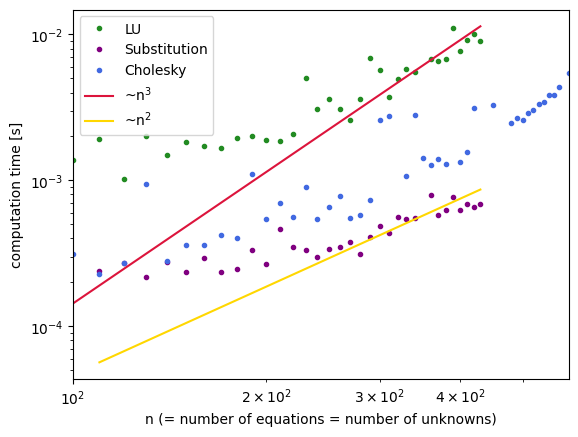

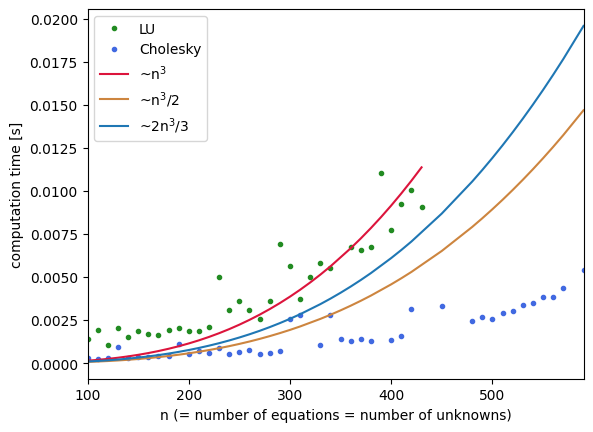

In [30]:
def plot_timings():
    # fit a polynomial to the data
    def cost_luf(x, a1):
        return a1 * x**3.0

    def cost_tri(x, a2):
        return a2 * x**2.0

    popt_luf = optimize.curve_fit(cost_luf, sizes_luf, timings_luf)[0]
    popt_tri = optimize.curve_fit(cost_tri, sizes_tri, timings_tri)[0]

    # plot the results of the previous operations
    plt.close("time1")
    fig, ax = plt.subplots(num="time1")
    ax.set_xlim(sizes.min(), sizes.max())
    ax.plot(sizes_luf, timings_luf, ".", label="LU", c="forestgreen")
    ax.plot(sizes_tri, timings_tri, ".", label="Substitution", c="purple")
    ax.plot(sizes_cho, timings_cho, ".", label="Cholesky", c="royalblue")
    ax.plot(sizes_luf, cost_luf(sizes_luf, popt_luf), label="~n$^3$", c="crimson")
    ax.plot(sizes_tri, cost_tri(sizes_tri, popt_tri), label="~n$^2$", c="gold")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("n (= number of equations = number of unknowns)")
    ax.set_ylabel("computation time [s]")
    ax.legend()

    plt.close("time2")
    fig, ax = plt.subplots(num="time2")
    ax.set_xlim(sizes.min(), sizes.max())
    ax.plot(sizes_luf, timings_luf, ".", label="LU", c="forestgreen")
    ax.plot(sizes_cho, timings_cho, ".", label="Cholesky", c="royalblue")
    ax.plot(sizes_luf, cost_luf(sizes_luf, popt_luf), label="~n$^3$", c="crimson")
    ax.plot(
        sizes_cho, cost_luf(sizes_cho, popt_luf / 2), label="~n$^3 /2$", c="peru"
    )
    ax.plot(
        sizes_cho, cost_luf(sizes_cho, 2*popt_luf / 3), label="~2n$^3 /3$"
    )
    ax.set_xlabel("n (= number of equations = number of unknowns)")
    ax.set_ylabel("computation time [s]")
    ax.legend()


plot_timings()

**Warning**: if you don't use sufficiently large matrices (>5000x5000) in the example above it seems that LU-factorization scales with O(n^2). 

According to the [scipy docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu_factor.html#scipy.linalg.lu_factor) it implements the *GETRF routines from [LAPACK](https://www.intel.com/content/www/us/en/develop/documentation/onemkl-developer-reference-c/top/lapack-routines/lapack-linear-equation-routines/lapack-linear-equation-computational-routines/matrix-factorization-lapack-computational-routines/getrf.html) which state that "The approximate number of floating-point operations for real flavors is (2/3)n^3 If m = n " in line with what we expect. 

## Sensitivity and Conditioning

We've seen how to find the solutions to a system of linear equations. Now let's consider how sensitive this solution is to small changes in the inputs. To do this we need to introduce a few concepts to extend the idea of an absolute value of a *scalar* to the **norm** of a *vector* or *matrix*.

### Vector norms

There's more than one way to define a "size" of a vector, but all the **vector norms** we will consider here are **p-norms**, which for an integer $p>0$ and an $n$-vector $\mathbf{x}$ are defined as

$$
\|\mathbf{x}\|_p=\left(\sum_{i=1}^n\|x_i\|^p\right)^{1/p}
$$

Important cases:

- **1-norm** or **Manhattan norm** (because in two dimensions it corresponds to the distance between two points as measured in "city blocks":

    $$
    \|\mathbf{x}\|_1=\sum_{i=1}^n\|x_i\|
    $$

- **2-norm** or **Euclidean norm** (because it corresponds to the usual notion of distance in Euclidean space):

    $$
    \|\mathbf{x}\|_2=\sqrt{\sum_{i=1}^n\|x_i\|^2}
    $$

- **$\infty$-norm** (the limit for $p\rightarrow \infty$):

    $$
   \|\mathbf{x}\|_\infty=\max_{1\leq i\leq n} \|x_i\|
    $$

> **Example**
>
> Consider the vector $\mathbf{x}=[-4 , 3]^\intercal$
>
> $\|\mathbf{x}\|_1=7$
>
> $\|\mathbf{x}\|_2=5$
>
> $\|\mathbf{x}\|_\infty =4$

The following cell calculates the p-norm for a vector $\mathbf{v}$, using code presented on @introductiontoscientificpr4335's [youtube channel](https://www.youtube.com/watch?time_continue=202&v=ICRs6AY_0CQ&feature=emb_title)

In [17]:
def pnorm(v, p):
    """function that calculates the p-norm for a vector v"""
    n = len(v)
    pn = 0
    for i in range(n):
        pn = pn + np.abs(v[i]) ** p
    pn = pn ** (1 / p)
    return pn

The function cannot compute the norm for $p > 11$ due to the factor $\frac{1}{p}$.
It is better to use the SciPy function to calculate the norm.

In [18]:
v = np.array([-4, 3])
for p in range(1, 11):
    print(f"{p}-norm:{pnorm(v, p)}")

1-norm:7.0
2-norm:5.0
3-norm:4.497941445275415
4-norm:4.284572294953817
5-norm:4.174027662897746
6-norm:4.110704132575835
7-norm:4.072242319397026
8-norm:4.04799203437848
9-norm:4.032307299196485
10-norm:4.021974149822332


Note that the norm very quickly converges to the maximum element of the vector for large values of $p$.

In general, for any $n$-vector $\mathbf{x}$:

$$
\|\mathbf{x}\|_1\geq\|\mathbf{x}\|_2\geq\|\mathbf{x}\|_\infty
$$

and

$$
\|\mathbf{x}\|_1\leq \sqrt{n}\|\mathbf{x}\|_2\\
\|\mathbf{x}\|_2\leq \sqrt{n}\|\mathbf{x}\|_\infty\\
\|\mathbf{x}\|_1\leq n\|\mathbf{x}\|_\infty\\
$$

And for all p-norms, the following properties hold:
- $\|\mathbf{x}\| > 0$ if $\mathbf{x} \neq \mathbf{0}$
- $\|\gamma \mathbf{x}\| = |\gamma|\cdot \|\mathbf{x}\|$ for any scalar $\gamma$
- $\|\mathbf{x}+\mathbf{y}\| \leq \|\mathbf{x}\|+\|\mathbf{y}\|$ (triangle inequality)


"Circles with different norms", a.k.a. [superellipses](https://en.wikipedia.org/wiki/Superellipse), are visualized below:

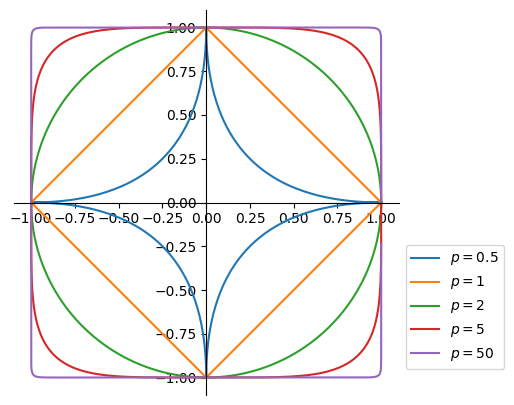

In [19]:
def unitball2d(pvals):
    plt.close("unitball2d")
    fig, ax = plt.subplots(figsize=(6, 5), num="unitball2d")
    theta = np.linspace(0, np.pi * 2, 370)
    for p in pvals:
        x0 = np.cos(theta)
        y0 = np.sin(theta)
        x1 = abs(x0) ** (2 / p) * np.sign(x0)
        y1 = abs(y0) ** (2 / p) * np.sign(y0)
        ax.plot(x1, y1, label=f"$p = {p}$")
    ax.set_aspect("equal")
    ax.spines["left"].set_position("center")
    ax.spines["right"].set_color("none")
    ax.spines["bottom"].set_position("center")
    ax.spines["top"].set_color("none")
    ax.legend(loc="lower left", bbox_to_anchor=(1.0, 0.05))


unitball2d(pvals=[0.5, 1, 2, 5, 50])

### Matrix norms

To get a measure for the size of a matrix, we define a **matrix norm** using the definitions of vector norms.

The norm of an $m\times n$ matrix $\mathbf{A}$ is given by

$$
\|\mathbf{A}\|=\max_{\mathbf{x\neq0}}\frac{\|\mathbf{Ax}\|}{\|\mathbf{x}\|},
$$

which corresponds to the maximum stretching the matrix does to a vector, as measured using a given vector norm.

Two cases that are easy to calculate are:

- $\|\mathbf{A}\|_1$, which corresponds the maximum absolute *column* sum of the matrix:

    $$
    \|\mathbf{A}\|_1=\max_j\sum_{i=1}^m\|a_{ij}\|
    $$
  
- $\|\mathbf{A}\|_\infty$, which corresponds the maximum absolute *row* sum of the matrix:

    $$
    \|\mathbf{A}\|_\infty=\max_i\sum_{j=1}^n\|a_{ij}\|
    $$

Unfortunately, the Euclidean norm is not so easy to calculate as it corresponds to the square root of the largest eigenvalue of $\mathbf{A^\intercal A}$ (see the chapter on eigenvalues).

> **Example**
>
> Consider the matrix
>
> $$\mathbf{A}=\begin{bmatrix} 
1 & -3 & 5\\
2 & 0 & 4\\
0 & -1 & 2
\end{bmatrix}$$
>
> The norms corresponding to the maximum row and column sums are:
>
> $$\|\mathbf{A}\|_1=11$$
>
> $$\|\mathbf{A}\|_\infty=9$$

Important properties of matrix norms:
- $\|\mathbf{A}\| > 0$ if $\mathbf{A} \neq \mathbf{0}$
- $\|\gamma \mathbf{A}\|= |\gamma| \cdot \|\mathbf{A}\|$, for any scalar $\gamma$
- $\|\mathbf{A}+\mathbf{B}\| \leq \|\mathbf{A}\|+\|\mathbf{B}\|$
- $\|\mathbf{A}\mathbf{B}\| \leq \|\mathbf{A}\|\cdot\|\mathbf{B}\|$
- $\|\mathbf{A}\mathbf{x} \|\leq \|\mathbf{A}\| \cdot \|\mathbf{x}\|$, for any vector $\mathbf{x}$

### Matrix condition number

The **condition number** of a nonsingular square matrix $\mathbf{A}$ with respect to a given matrix norm is given by

$$
\mathrm{cond}(\mathbf{A})=\|\mathbf{A}\|\cdot\|\mathbf{A}^{-1}\|
$$

By convention, the condition number of a singular matrix is $\infty$.

The condition number is a measure of how close a matrix is to being singular. The minimal condition number is 1 which only occurs for orthogonal matrices. A condition number close to 1 corresponds to a well-posed problem, whereas a very large condition number tells you that a solution of a linear system will change drastically for small changes in the input data.

> **Example**
>
> The inverse of the matrix from the previous example
> 
> $$\mathbf{A}=\begin{bmatrix} 
1 & -3 & 5\\
2 & 0 & 4\\
0 & -1 & 2
\end{bmatrix}$$
>
> is
> 
> $$\mathbf{A}^{-1}=\begin{bmatrix} 
2/3 & 1/6 & -2\\
-2/3 & 1/3 & 1\\
-1/3 & 1/6 & 1
\end{bmatrix}$$
>
> so that $\|\mathbf{A^{-1}}\|_1=4$ and $\|\mathbf{A^{-1}}\|_\infty=17/6$
>
> Thus the condition numbers are
>
> $$\mathrm{cond}_1(\mathbf{A})=\|\mathbf{A}\|_1\cdot\|\mathbf{A^{-1}}\|_1= 11 \cdot 4=44$$
>
> and
>
> $$\mathrm{cond}_\infty(\mathbf{A})=\|\mathbf{A}\|_\infty\cdot\|\mathbf{A^{-1}}\|_\infty= 9 \cdot 17/6=25.5$$

Note that, because there is a strict order in the size of the different matrix norms (the 1-norm is always larger than the 2-norm, and so on) it doesn't matter too much which norm is used to estimate the condition number, as they will all give the same relative idea of how well-posed the problem underlying your linear system is.

### Error estimation

Next to an estimate of how near a matrix is to being singular, the condition number also gives an estimate for the error on the solution of a system of linear equations.

Consider the non-singular system $\mathbf{Ax}=\mathbf{b}$ with solution $\mathbf{x}$. Additionally, let $\mathbf{x'}$ be the solution to the perturbed system $\mathbf{Ax'}=\mathbf{b}+\Delta\mathbf{b}$, and define the difference between both solutions $\mathbf{x}'-\mathbf{x}$ as $\Delta\mathbf{x}$. 

This results in

$$
\mathbf{Ax'}=\mathbf{A}(\mathbf{x}+\Delta\mathbf{x})=\mathbf{Ax}+\mathbf{A}\Delta\mathbf{x}=\mathbf{b}+\Delta\mathbf{b}
$$

Consequently, $\mathbf{A}\Delta\mathbf{x}=\Delta\mathbf{b}$, and hence $\Delta\mathbf{x}=\mathbf{A}^{-1}\Delta\mathbf{b}$.

Taking norms, and using the properties listed above we find:
- $\|\mathbf{b}\|=\|\mathbf{Ax}\|\leq\|\mathbf{A}\|\cdot\|\mathbf{x}\|$ or $\|\mathbf{x}\|\geq \frac{\|\mathbf{b}\|}{\|\mathbf{A}\|}$
- $\|\Delta\mathbf{x}\|=\|\mathbf{A}^{-1}\Delta\mathbf{b}\|\leq\|\mathbf{A}^{-1}\|\cdot\|\Delta\mathbf{b}\|$

Combining both equalities gives

$$
\frac{\|\Delta\mathbf{x}\|}{\|\mathbf{x}\|}\leq\mathrm{cond}(\mathbf{A})\frac{\|\Delta\mathbf{b}\|}{\|\mathbf{b}\|}
$$

The condition number thus acts as an "amplification factor" for the relative change in the solution with respect to a relative change in the right hand sided vector. 

> **Example**
>
> Let's verify the expression above by revisiting a previous example and see how a perturbation in $\mathbf{b}$ affects the solution of the following linear system:
>
> $$\mathbf{Ax}=\begin{bmatrix}
1 & 2 & 2 \\
4 & 4 & 2 \\
4 & 6 & 4 
\end{bmatrix} \begin{bmatrix}
x_1 \\
x_2 \\
x_3 
\end{bmatrix}=\begin{bmatrix}
3 \\
6 \\
10 
\end{bmatrix}=\mathbf{b}$$
>
> Remember that the solution $\mathbf{x}$ of this system was found to be equal to $[-1 \quad  3 \ -1]^\intercal$.
>
> If a perturbation $\Delta\mathbf{b} = [-1.8 \ 0 \quad0]^\intercal$ is applied to vector $\mathbf{b}$, the linear system to be solved becomes: 
>
> $$\mathbf{Ax'}=\begin{bmatrix}
1 & 2 & 2 \\
4 & 4 & 2 \\
4 & 6 & 4 
\end{bmatrix} \begin{bmatrix}
x'_1 \\
x'_2 \\
x'_3 
\end{bmatrix}=\begin{bmatrix}
1.2 \\
6 \\
10 
\end{bmatrix}=\mathbf{b'}$$
>
> with a solution $\mathbf{x'} = [-2.8 \quad 6.6 \ -4.6]^\intercal$. Hence, 
>
> $$ \Delta\mathbf{x} = \mathbf{x'}-\mathbf{x} = \begin{bmatrix}
  -1.8 \\
  3.6 \\
  -3.6 
  \end{bmatrix} \quad\Rightarrow\quad \frac{\|\Delta\mathbf{x}\|_1}{\|\mathbf{x}\|_1} = \frac{9}{5} = 1.8 $$
>
> While 
>
> $$\frac{\|\Delta\mathbf{b}\|_1}{\|\mathbf{b}\|_1} = \frac{1.8}{19} \approx 0.095$$
>
> Note that the relative change in $\mathbf{x}$ is larger that the relative change in $\mathbf{b}$ but that the following expression (with $\mathrm{cond}(\mathbf{A}) = 60$) still holds:
>
> $$
1.8 = \frac{\|\Delta\mathbf{x}\|}{\|\mathbf{x}\|} \leq \mathrm{cond}(\mathbf{A})\frac{\|\Delta\mathbf{b}\|}{\|\mathbf{b}\|}=60\cdot\frac{1.8}{19} \approx 5.68,
$$

A similar reasoning (which is left as an **exercise**) learns us that for deviations $\mathbf{E}$ in the matrix $\mathbf{A}$, such that $(\mathbf{A}+\mathbf{E})\mathbf{x'}=\mathbf{b}$, we find

$$
\frac{\|\Delta\mathbf{x}\|}{\|\mathbf{x}'\|}\leq\mathrm{cond}(\mathbf{A})\frac{\|\mathbf{E}\|}{\|\mathbf{A}\|}
$$


In [25]:
# Exercise: Impact of perturbations in matrix A

# Setup
np.random.seed(42)
n = 3
A = np.array([[10, 1, 2],
              [1, 8, 0.5],
              [2, 0.5, 6]], dtype=float)

b = np.array([1, 1, 1], dtype=float)

# Original solution
x_orig = np.linalg.solve(A, b)

# Add perturbation E to matrix A
# We want: (A + E) x' = b
# This gives: x' = (A + E)^{-1} b
relative_perturbation_A = 0.05  # 5% perturbation in A

E = relative_perturbation_A * np.random.randn(n, n)
A_perturbed = A + E

# New solution with perturbed matrix
x_perturbed = np.linalg.solve(A_perturbed, b)

# Compute relative changes
delta_x = x_perturbed - x_orig
rel_error_x = np.linalg.norm(delta_x) / np.linalg.norm(x_orig)
rel_error_A = np.linalg.norm(E) / np.linalg.norm(A)

# Compute condition number
cond_A = np.linalg.cond(A)

# The bound says: ||Δx|| / ||x'|| ≤ cond(A) * ||E|| / ||A||
bound = cond_A * rel_error_A

print(f"Condition number of A: {cond_A:.2f}")
print(f"Relative perturbation in A: {rel_error_A:.4f}")
print(f"Relative error in x: {rel_error_x:.4f}")
print(f"Upper bound (cond(A) × ||E||/||A||): {bound:.4f}")
print(f"\nBound satisfied: {rel_error_x <= bound * 1.01}  (with 1% tolerance)")
print(f"Amplification factor: {rel_error_x / rel_error_A:.2f}x")

Condition number of A: 2.17
Relative perturbation in A: 0.0087
Relative error in x: 0.0050
Upper bound (cond(A) × ||E||/||A||): 0.0189

Bound satisfied: True  (with 1% tolerance)
Amplification factor: 0.57x


Because the condition number cannot be smaller than 1 (and is only 1 for the identity matrix), relative errors in your inputs will always result in larger relative errors in the solution of your linear system. 

Also note that, because the vector norm is dominated by the largest components of a vector, the relative error on the smallest components of the solution vector can be much larger than the relative error on the largest components.

### Residual

An easy way to check the correctness of your solution to a system of linear equations is to fill it in the system and see whether the two sides of the equation are equal.
The **residual** $\mathbf{r}$ of an approximate solution $\mathbf{x}'$ of the system $\mathbf{Ax}=\mathbf{b}$ is defined as

$$
\mathbf{r}=\mathbf{b}-\mathbf{Ax'}
$$

In theory, for a nonsingular $\mathbf{A}$, the residual $\mathbf{r}=0$ if and only if the error $\|\mathbf{x}-\mathbf{x}'\|=0$. In practice, they are not necessarily small simultaneously. 

If we multiply the system $\mathbf{Ax}=\mathbf{b}$ by an arbitrary number, the solution will remain the same, whereas the residual will be multiplied by the same number. Therefore, it only makes sense to work with a **relative residual** 

$$\frac{\|\mathbf{r}\|}{(\|\mathbf{A}\|\cdot \|\mathbf{x}'\|)}$$

To relate the error to the residual, we observe

$$
\|\Delta\mathbf{x}\|=\|\mathbf{x'}-\mathbf{x}\|=\|\mathbf{A}^{-1}(\mathbf{Ax'}-\mathbf{b})\|=\|-\mathbf{A}^{-1}\mathbf{r}\|\leq\|\mathbf{A}^{-1}\|\cdot\|\mathbf{r}\|
$$

Dividing both sized by $\|\mathbf{x}'\|$ and filling in the definition of $\mathrm{cond}(\mathbf{A})$, we find

$$
\frac{  \|\Delta\mathbf{x}\|   }{  \|\mathbf{x'}\|  }  \leq\mathrm{cond}(\mathbf{A})  \frac{\|\mathbf{r}\|}{\|\mathbf{A}\|\cdot\|\mathbf{x'}\|}
$$

Therefore, a small residual implies a small relative error in the solution *only* if the matrix $\mathbf{A}$ has a small condition number.


## Software

To work with systems of linear equations in python, we prefer the use of `scipy.linalg` which contains all the functions in `numpy.linalg` plus some other more advanced ones not contained in `numpy.linalg`.

The documentation for `scipy.linalg` can be found here: 

<https://docs.scipy.org/doc/scipy/reference/linalg.html>

together with lots of useful tutorials here:

<https://docs.scipy.org/doc/scipy/tutorial/linalg.html>

### Solving systems of linear equations

For the generic case, `scipy.linalg.solve` uses lapack gesv, which is based on LU factorization,

for more specific cases, symmetric, positive definite, banded, more specialized routines based e.g. on Cholesky factorization are used.

As an example, the next cell shows how to solve the system used in the examples above using `linalg.solve`. and how to perform an LU factorization using `linalg.lu`, which returns the permutation matrix $\mathbf{P}$, used to pivot the matrix $\mathbf{A}$ and the lower and upper triangular matrices $\mathbf{L}$ and $\mathbf{U}$, respectively.

These examples all use the same matrices as in the examples shown above.

In [20]:
A = np.array([[1, 2, 2], [4, 4, 2], [4, 6, 4]])
b = np.array([3, 6, 10])
x = linalg.solve(A, b)
print(x, "\n")

[-1.  3. -1.] 



In [21]:
P, L, U = linalg.lu(A)
print("Matrix A =\n", A, "\n")
print("Permutation matrix P =\n", P, "\n")
print("Lower triangular matrix L =\n", L, "\n")
print("Upper triangular matrix U =\n", U, "\n")
print("Reconstructed matrix (P @ L @ U) =\n", P @ L @ U, "\n")

Matrix A =
 [[1 2 2]
 [4 4 2]
 [4 6 4]] 

Permutation matrix P =
 [[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]] 

Lower triangular matrix L =
 [[1.   0.   0.  ]
 [1.   1.   0.  ]
 [0.25 0.5  1.  ]] 

Upper triangular matrix U =
 [[4.  4.  2. ]
 [0.  2.  2. ]
 [0.  0.  0.5]] 

Reconstructed matrix (P @ L @ U) =
 [[1. 2. 2.]
 [4. 4. 2.]
 [4. 6. 4.]] 



Once you have the LU factorization, you can use it to efficiently solve your linear system (especially if you have multiple $\mathbf{b}$ vectors for which you want to solve it) using `linalg.lu_solve`.

In [22]:
A = np.array([[1, 2, 2], [4, 4, 2], [4, 6, 4]])
b = np.array([3, 6, 10])
lu, piv = linalg.lu_factor(A)
x = linalg.lu_solve((lu, piv), b)
print(x)

[-1.  3. -1.]


The Cholesky factorization can be calculated with `linalg.cholesky`. 

In [23]:
a = np.array([[4, 2, 6], [2, 2, 5], [6, 5, 22]])
L = linalg.cholesky(a, lower=True)

print(L)

[[2. 0. 0.]
 [1. 1. 0.]
 [3. 2. 3.]]


In [24]:
# There are also functions to calculate the inverse of a matrix and its norm

A = np.array([[1.0, -3.0, 5.0], [2.0, 0.0, 4.0], [0.0, -1.0, 2.0]])

print("The 1-norm of A equals: ", linalg.norm(A, 1))
print("The infty-norm of A equals: ", linalg.norm(A, np.inf))

B = linalg.inv(A)

print("\n\nThe inverse of A is: \n", B, "\n\n")
print("The 1-norm of A^-1 equals: ", linalg.norm(B, 1))
print("The infty-norm of A^-1 equals: ", linalg.norm(B, np.inf))

print("\n\nThe condition number of A, thus is:")
print(linalg.norm(A, 1) * linalg.norm(B, 1), " for the 1-norm")
print(linalg.norm(A, np.inf) * linalg.norm(B, np.inf), " for the infty-norm")

# TODO add condition number

The 1-norm of A equals:  11.0
The infty-norm of A equals:  9.0


The inverse of A is: 
 [[ 0.66666667  0.16666667 -2.        ]
 [-0.66666667  0.33333333  1.        ]
 [-0.33333333  0.16666667  1.        ]] 


The 1-norm of A^-1 equals:  4.0
The infty-norm of A^-1 equals:  2.833333333333333


The condition number of A, thus is:
44.0  for the 1-norm
25.499999999999996  for the infty-norm
